![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Taller: Análisis de Sentimientos y Técnicas de NLP

En este taller podrán poner en práctica sus conocimientos sobre las diferentes técnicas para el procesamiento de lenguaje natural. El taller está constituido por 5 puntos, en los cuales deberan seguir las intrucciones de cada numeral para su desarrollo.

## Datos predicción sentimientos de viajeros en Twitter

En este taller se usará el conjunto de datos de sentimientos sobre distintas aerolíneas de EE.UU. provenientes de Twitter. Cada observación contiene si el sentimiento de los tweets es positivo, neutral o negativo teniendo en cuenta distintas variables como aerolínea y las razones de los sentimientos negativos (como "retraso en el vuelo" o "servicio grosero"). El objetivo es predecir el sentimiento asociado a cada tweet. Para más detalles pueden visitar el siguiente enlace: [datos](https://www.kaggle.com/crowdflower/twitter-airline-sentiment).

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
!pip install -U nltk 


[notice] A new release of pip is available: 24.3.1 -> 25.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
# Descargar los paquetes necesarios de nltk
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\kevin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\kevin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\kevin\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [4]:
# Librerías
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
%matplotlib inline

In [5]:
# Lectura de la información de archivo .zip
tweets = pd.read_csv('https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/datasets/Tweets.zip', index_col=0)

# Visualización
tweets.head()

,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
tweet_id,,,,,,,,,,,,,,
570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [6]:
# Tamaño del set de datos
tweets.shape

(14640, 14)

### Análisis Descriptivo

In [7]:
# Cuenta de tweets por cada sentimiento
tweets['airline_sentiment'].value_counts()

airline_sentiment
negative    9178
neutral     3099
positive    2363
Name: count, dtype: int64

In [8]:
# Cuenta de tweets por cada aerolínea
tweets['airline'].value_counts()

airline
United            3822
US Airways        2913
American          2759
Southwest         2420
Delta             2222
Virgin America     504
Name: count, dtype: int64

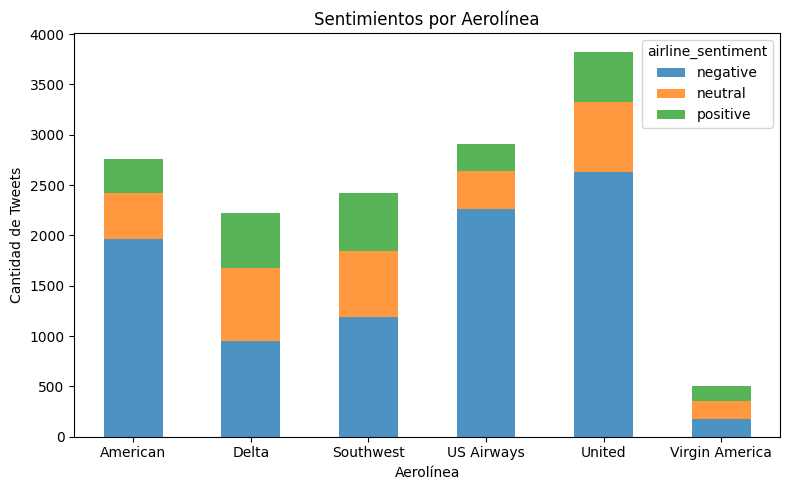

In [9]:
# Gráfico de tweets por cada aerolínea y tipo de sentimiento
pd.crosstab(index=tweets["airline"], columns=tweets["airline_sentiment"]).plot(
    kind='bar',
    figsize=(8, 5),
    alpha=0.8,  # Más opaco (ajusté el alpha a 0.8 para que se vea mejor)
    rot=0,
    stacked=True,
    title="Sentimientos por Aerolínea",
    color=['#1f77b4', '#ff7f0e', '#2ca02c']
)

plt.xlabel("Aerolínea")
plt.ylabel("Cantidad de Tweets")
plt.tight_layout()
plt.show()

In [10]:
# Separación de variables predictoras (X) y de variable de interés (y)
X = tweets['text']
y = tweets['airline_sentiment'].map({'negative':-1,'neutral':0,'positive':1})

In [11]:
# Separación de datos en set de entrenamiento y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=17)

### Punto 1 - Uso de CountVectorizer

En la celda 1 creen un modelo de random forest con la libreria sklearn que prediga el sentimiento de los tweets usando los set de entrenamiento y test definidos anteriormente. Usen la función **CountVectorizer** y presenten el desempeño del modelo con la métrica del acurracy.

Recuerden que el preprocesamiento que se haga sobre los datos de entrenamiento  (*.fit_transform()*) deben ser aplicado al set de test (*.transform()*).

In [12]:
# Preprocesamiento de texto con CountVectorizer
vectorizer = CountVectorizer()
X_train_vect = vectorizer.fit_transform(X_train)
X_test_vect = vectorizer.transform(X_test)

# Modelo RandomForestRegressor
model = RandomForestClassifier(random_state=0)

# Entrenamiento del modelo
model.fit(X_train_vect, y_train)

# Predección de los valores para el conjunto de prueba
y_pred = model.predict(X_test_vect)

# Accuracy
accuracy_vectorizer = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy_vectorizer)

Accuracy: 0.761796357615894


### Análisis de Resultados

Se utiliza CountVectorizer para procesar los tweets y luego de aplicar un modelo de **Random Forest Classifier** el accuracy es de 76.2%, lo que indica que fue capaz de hacer predicciones relativamente confiables. Este método de preprocesamiento tiene puntos importantes de mejora, no tiene en cuenta la relevancia de las palabras en un contexto o tomar palabras que sean sinónimos como palabras diferentes.

### Punto 2 - Eliminación de Stopwords

En la celda 2 creen un modelo de random forest con la libreria sklearn que prediga el sentimiento de los tweets usando los set de entrenamiento y test definidos anteriormente. Usen la función CountVectorizer, **eliminen stopwords** y presenten el desempeño del modelo con la métrica del acurracy.

Recuerden que el preprocesamiento que se haga sobre los datos de entrenamiento  (*.fit_transform()*) deben ser aplicado al set de test (*.transform()*).

In [ ]:
# Vectorización eliminando stopwords en inglés
vectorizer = CountVectorizer(stop_words='english')
X_train_vect = vectorizer.fit_transform(X_train)
X_test_vect = vectorizer.transform(X_test)

# Crear y entrenar el modelo de Random Forest
model_sin_stopwords = RandomForestClassifier(random_state=0)
model_sin_stopwords.fit(X_train_vect, y_train)

# Predicción y evaluación
y_pred1 = model_sin_stopwords.predict(X_test_vect)
accuracy_sin_stopwords = accuracy_score(y_test, y_pred)

# Mostrar resultado
print("Accuracy del modelo sin stopwords:", accuracy_sin_stopwords)


Accuracy del modelo sin stopwords: 0.7566225165562914


In [23]:
print("Modelo con stopwords")
print(classification_report(y_test, y_pred))
print("Modelo sin stopwords")
print(classification_report(y_test, y_pred1))

Modelo con stopwords
              precision    recall  f1-score   support

          -1       0.82      0.89      0.85      3046
           0       0.59      0.48      0.53      1032
           1       0.68      0.58      0.62       754

    accuracy                           0.76      4832
   macro avg       0.69      0.65      0.67      4832
weighted avg       0.74      0.76      0.75      4832

Modelo sin stopwords
              precision    recall  f1-score   support

          -1       0.82      0.89      0.85      3046
           0       0.59      0.48      0.53      1032
           1       0.68      0.58      0.62       754

    accuracy                           0.76      4832
   macro avg       0.69      0.65      0.67      4832
weighted avg       0.74      0.76      0.75      4832



### Análisis de Resultados

Al utilizar CountVectorizer sin utilizar las "stopwords" del idioma inglés, se obtiene un accuracy del 75.7%. Este resultado indica que eliminar las stopwords tiene un efecto negativo. Estos resultados van a depender del contexto de los datos que se está utilizando, para este caso, parece que los stopwords aportaban valor en la predicción.

Ahora, nuestra hipótesis es que al quitar las stopwords pueda que se quite información útil a nivel contextual, así que se aplica un segmento de código que permite validar que los textos cortos es importante cada palabra, sobre todo en el análisis de sentimiento. Las stopwords como "not", "never", "won’t", "just", "still" tienen valor semántico en análisis de sentimientos. 

### Punto 3 - Lematización con Verbos

En la celda 3 creen un modelo de random forest con la libreria sklearn que prediga el sentimiento de los tweets usando los set de entrenamiento y test definidos anteriormente. Usen la función CountVectorizer, **lematizen el texto con verbos** y presenten el desempeño del modelo con la métrica del acurracy.

Recuerden que el preprocesamiento que se haga sobre los datos de entrenamiento  (*.fit_transform()*) deben ser aplicado al set de test (*.transform()*).

In [15]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kevin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [16]:
# Inicializar lematizador y stopwords
wordnet_lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Función personalizada: lematización como verbo + eliminar stopwords
def split_into_lemmas(text):
    text = text.lower()
    words = text.split()
    return [
        wordnet_lemmatizer.lemmatize(word, pos='v')
        for word in words if word not in stop_words
    ]

# Crear CountVectorizer con función personalizada
vectorizer = CountVectorizer(analyzer=split_into_lemmas)

# Vectorizar los datos
X_train_vect = vectorizer.fit_transform(X_train)
X_test_vect = vectorizer.transform(X_test)

# Modelo Random Forest
modelo_rf = RandomForestClassifier(random_state=0)
modelo_rf.fit(X_train_vect, y_train)

# Predicción y evaluación
y_pred = modelo_rf.predict(X_test_vect)
accuracy_lema = accuracy_score(y_test, y_pred)

# Mostrar resultado
print("Accuracy del modelo de Random Forest con lematización y stopwords (corregido):", accuracy_lema)

Accuracy del modelo de Random Forest con lematización y stopwords (corregido): 0.7485513245033113


### Análisis de Resultados

Al utilizar CounVectorizer y procesar el texto con lematización de verbos y utilizando nuevamente el modelo de Random Forest Classifier obtenemos un accuracy del 74.9%, lo cual mejora ligeramente el modelo en comparación con solo eliminar las stopwords. No supera el modelo base, lo que podría generarse porque al quitar las palabras comunes podría estar quitando informaciómn útil. 

### Punto 4 - Multiples Técnicas

En la celda 4 creen un modelo de random forest con la libreria sklearn que prediga el sentimiento de los tweets usando los set de entrenamiento y test definidos anteriormente. Usen la función **CountVectorizer, eliminen stopwords, lematizen el texto con verbos** y presenten el desempeño del modelo con la métrica del acurracy.

Recuerden que el preprocesamiento que se haga sobre los datos de entrenamiento  (*.fit_transform()*) deben ser aplicado al set de test (*.transform()*).

In [17]:
wordnet_lemmatizer = WordNetLemmatizer()

# función para lematizar el texto con verbos
def split_into_lemmas(text):
    text = text.lower()
    words = text.split()
    return [wordnet_lemmatizer.lemmatize(word , pos='v') for word in words]

# Crear un objeto CountVectorizer con la función de lematización split_into_lemmas
vectorizer = CountVectorizer(stop_words='english', analyzer=split_into_lemmas)

X_train_vect = vectorizer.fit_transform(X_train)
X_test_vect = vectorizer.transform(X_test)

# Crear y entrenar el modelo de Random Forest
modelo_rf = RandomForestClassifier(random_state=0)
modelo_rf.fit(X_train_vect, y_train)

y_pred = modelo_rf.predict(X_test_vect)

accuracy_all = accuracy_score(y_test, y_pred)

# Imprimir el accuracy del modelo
print("Accuracy del modelo de Random Forest con todos los pasos de preprocesamiento:", accuracy_all)

Accuracy del modelo de Random Forest con todos los pasos de preprocesamiento: 0.7437913907284768


### Análisis de Resultados

En el punto 4 utilizamos el método CountVectorizer y a continuación procesamos los tweets sin las stopwords y lematizando los verbos. Al igual que en puntos anteriores aplicamos el modelo de Random Forest Classifier obteniendo un accuracy de 74.4% que es el resultado más bajo de las 4 variaciones de procesamiento de texto. Este resultado es contradictorio teniendo en cuenta que habíamos visto mejoras usando lematización, pero nuevamente esto podría darnos información del contexto de los datos que estamos analizando y qué tan beneficioso es o no quitar las stopwords aunque apliquemos lematización.

### Punto 5 - Comparación y Análisis de Resultados

En la celda 5 comparen los resultados obtenidos de los diferentes modelos (random forest) y comenten las ventajas del mejor modelo y las desventajas del modelo con el menor desempeño.

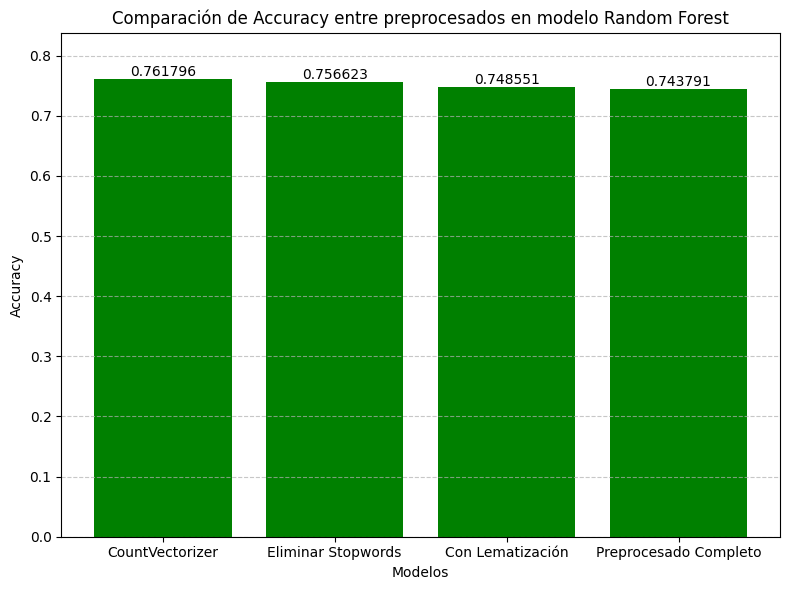

In [24]:
# Gráfica de barras
plt.figure(figsize=(8, 6))
plt.bar(["CountVectorizer", "Eliminar Stopwords", "Con Lematización", "Preprocesado Completo"],
        [accuracy_vectorizer, accuracy_sin_stopwords, accuracy_lema, accuracy_all],
        color='green')  

# Agregar etiquetas a las barras
for i, valor in enumerate([accuracy_vectorizer, accuracy_sin_stopwords, accuracy_lema, accuracy_all]):
    plt.text(i, valor, f'{valor:.6f}', ha='center', va='bottom')

# Títulos y etiquetas
plt.xlabel('Modelos')
plt.ylabel('Accuracy')
plt.title('Comparación de Accuracy entre preprocesados en modelo Random Forest')
plt.ylim(0, max([accuracy_vectorizer, accuracy_sin_stopwords, accuracy_lema, accuracy_all]) * 1.1)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Mostrar la gráfica
plt.tight_layout()
plt.show()

### Conclusiones

Durante el preprocesamiento de los tweets se evaluaron distintas variantes: el uso del texto completo, la eliminación de stopwords, la lematización, y la combinación de eliminación de stopwords con lematización.

Los resultados mostraron que el mejor desempeño en términos de accuracy se obtuvo utilizando únicamente la lematización. En segundo lugar se ubicó la estrategia de utilizar el texto completo sin modificaciones. Esto sugiere que conservar las formas base de las palabras, en particular de los verbos, facilita que el modelo clasifique de manera más efectiva los sentimientos expresados en los tweets.

Finalmente, dado el contexto de análisis, se considera que mantener la mayor cantidad de contenido original del tweet puede ser beneficioso para comprender mejor la intención del mensaje. Además, la presencia de abreviaciones, modismos y otras formas informales de escritura propias de este tipo de plataformas podría estar aportando información importante, por lo que sería conveniente tenerlo en cuenta en futuras etapas de preprocesamiento para seguir optimizando el rendimiento del modelo.